In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import pymysql
import numpy as np
import pickle
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [2]:
def pickleLoad(file):
    if os.path.isfile(file):        
        with open(file,"rb") as fr:
            dataframe = pickle.load(fr)
        return dataframe
    else:  
        %run -i 'getTrainTestSet.py' 

In [3]:
# load train, test set data

X_train = pickleLoad('./dataset/X_train.pkl')
X_test = pickleLoad('./dataset/X_test.pkl')
y_train = pickleLoad('./dataset/y_train.pkl')
y_test = pickleLoad('./dataset/y_test.pkl')
ccsi = pickleLoad('./dataset/ccsi.pkl')
predictors = pickleLoad('./dataset/predictors.pkl')



## Step3. Modeling
### model 4. regression decision tree

* model fitting

In [4]:
# grid search를 해서, 최적의 파라미터를 갖는 트리 모델을 적합
param_grid = {'max_depth':[1,2,3,4,5,6,7,8,9,10,11], 'random_state': [23]}
model_tree = GridSearchCV( DecisionTreeRegressor(), param_grid, cv = 5, scoring = 'neg_mean_squared_error', return_train_score = True)

model_tree.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
                         'random_state': [23]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [5]:
model_tree.best_params_

{'max_depth': 5, 'random_state': 23}

* prediction

In [6]:
y_pred = model_tree.predict(X_test) # y_pred: test set을 넣어서 얻은 예측 값
y_pred

array([ 98.13076923, 112.4       ,  98.13076923, 108.1       ,
        93.35      ,  88.2       ,  98.13076923,  98.13076923,
        99.12727273,  98.13076923,  99.12727273, 112.4       ])

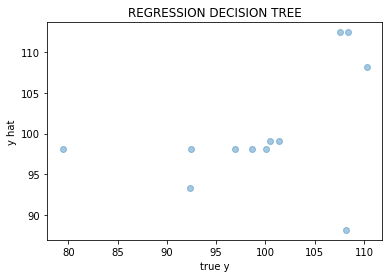

In [7]:
# test set에 대한 실제값과 예측 값의 추세 확인
plt.scatter(y_test, y_pred, alpha=0.4)
plt.xlabel("true y")
plt.ylabel("y hat")
plt.title("REGRESSION DECISION TREE")
plt.show()

* model evaluating<br>
: grid_search에서 score는 cost func이 아닌 utility func기준. <br>
따라서 minus를 붙여주어야함

In [8]:
print("training RMSE: ", np.sqrt(-model_tree.best_score_)) 
print("test RMSE: ", np.sqrt(-model_tree.score(X_test, y_test)))

training RMSE:  4.684293593367793
test RMSE:  8.37321344930187


## Step4. Validate

여러 모델들을 활용하여, validating 하는 단계

## Step5. Visualization
### weekly record 예측하기(weekly CCSI)

In [9]:
# weekly 레코드들을 예측 모델에 집어넣어, 각 레코드에 대한 예측값 얻음
pred_ccsi = model_tree.predict(predictors[['keyword1','keyword2','keyword3','keyword4','keyword5','google','naver']])

In [10]:
tmp = pd.merge(predictors, ccsi).drop(['id'], axis=1)
tmp['pred'] = pred_ccsi
tmp.head()

,year,month,day,keyword1,keyword2,keyword3,keyword4,keyword5,google,naver,ccsi,pred
0,2016,1,4,825,419,437,986,168,53.0,26.05846,99.5,93.350000
1,2016,1,11,770,348,351,626,182,58.0,25.16599,99.5,93.350000
2,2016,1,18,918,422,441,445,147,74.0,27.38639,99.5,98.130769
3,2016,1,25,1067,425,567,383,148,59.0,24.72622,99.5,98.130769
4,2016,2,1,899,341,485,289,110,63.0,23.01888,97.2,102.333333


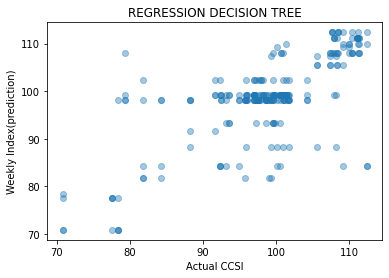

In [11]:
# true와 pred의 추세 확인
plt.scatter(tmp['ccsi'], tmp['pred'], alpha=0.4)
plt.xlabel("Actual CCSI")
plt.ylabel("Weekly Index(prediction)")
plt.title("REGRESSION DECISION TREE")
plt.show()

In [12]:
# weekly별 단기지표 값에 대한 MSE
print("MSE about weekly CCSI: ", np.sqrt(mean_squared_error(tmp['ccsi'], tmp['pred'])))

MSE about weekly CCSI:  6.8445062863988655


### visualization
* 시계열 그래프

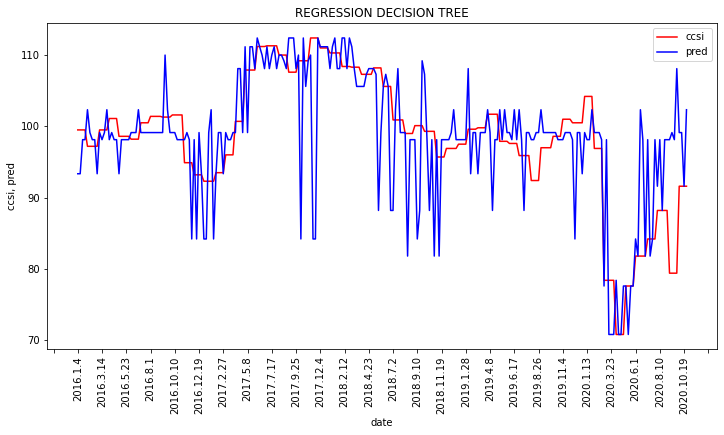

In [13]:
# 시계열 그래프를 그리기위해, 날짜 column 생성
tmp['date'] = tmp[['year', 'month', 'day']].apply(lambda x: '.'.join(map(str, x)), axis=1)

plt.rcParams["figure.figsize"] = (12, 6)
plt.plot(tmp['date'], tmp['ccsi'], color = 'red', label = 'ccsi')
plt.plot(tmp['date'], tmp['pred'], color = 'blue', label = 'pred')
plt.xlabel("date")
plt.ylabel("ccsi, pred")
ax = plt.subplot()
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
for label in ax.xaxis.get_ticklabels() :
    label.set_rotation(90)
plt.title("REGRESSION DECISION TREE")
plt.legend()
plt.show()

* moving avg 시계열 그래프

2주 간의 단기 지표들을 평균낸 값을 weekly CCSI로 활용하고자함. <br>
시각화 결과, 주간 레코드에 대한 예측 결과를 바로 활용하는 것 보다 2주 간의 예측 결과 평균을 활용하는 것이 덜 들쑥날쑥하다.

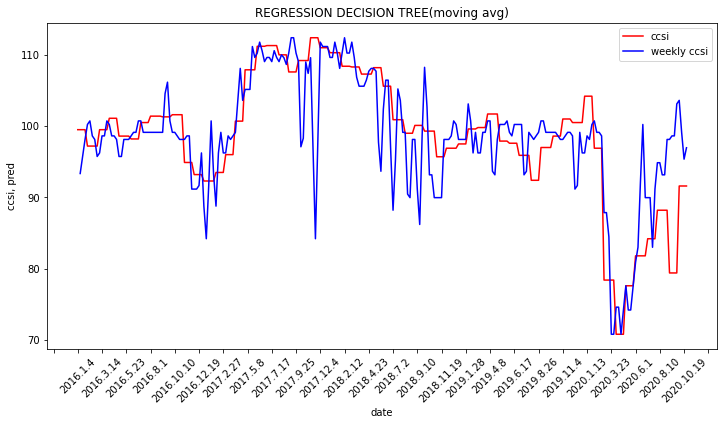

In [14]:
rolling = pd.Series.rolling(tmp['pred'], window = 2, center = False).mean()

plt.rcParams["figure.figsize"] = (12, 6)
plt.plot(tmp['date'], tmp['ccsi'], color = 'red', label = 'ccsi')
rolling.plot(color = 'blue', label = 'weekly ccsi')
plt.xlabel("date")
plt.ylabel("ccsi, pred")
ax = plt.subplot()
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
for label in ax.xaxis.get_ticklabels() :
    label.set_rotation(45)
plt.title("REGRESSION DECISION TREE(moving avg)")
plt.legend()
plt.show()